<a href="https://colab.research.google.com/github/suhaaskarthik/birdsong-classification/blob/main/audio_classification_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

birdclef_2024_path = kagglehub.competition_download('birdclef-2024')

print('Data source import complete.')


In [ ]:
!pip install resampy

In [ ]:
!pip install --upgrade librosa

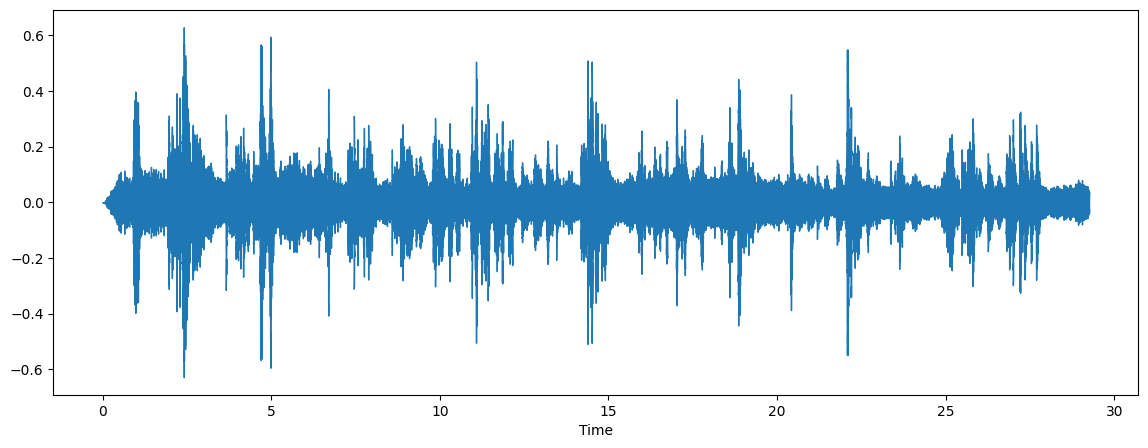

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
filename='/kaggle/input/birdclef-2024/train_audio/asbfly/XC175797.ogg'
plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveshow(data,sr=sample_rate)
ipd.Audio(filename)

In [ ]:
data

In [ ]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file)
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

    return mfccs_scaled_features

In [ ]:
x = features_extractor('/kaggle/input/birdclef-2024/train_audio/ashdro1/XC284493.ogg')
x.shape

(40,)

In [ ]:
import os
import numpy as np
bird_classes = os.listdir('/kaggle/input/birdclef-2024/train_audio')
BASE_DIR = '/kaggle/input/birdclef-2024/train_audio/'
files= []
labels = []
for ind,i in enumerate(bird_classes):
    for j in os.listdir(BASE_DIR+i):
        files.append(BASE_DIR+i+'/'+j)
        labels.append(ind)

In [ ]:
import tensorflow as tf
import io

In [ ]:
def load_audio(file_path):
    def _load_audio_numpy(file_path):
        file_path = file_path.numpy().decode("utf-8")
        audio, sample_rate = librosa.load(file_path)
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
        return mfccs_scaled_features
    features = tf.py_function(
        func=_load_audio_numpy,
        inp=[file_path],
        Tout=tf.float32
    )

    return features

In [ ]:
import random
random.seed(42)
random.shuffle(files)
random.seed(42)
random.shuffle(labels)
train_sample = int(len(files)*0.9)
training_files = files[:train_sample]
training_labels = labels[:train_sample]

testing_files = files[train_sample:]
testing_labels = labels[train_sample:]

In [ ]:

training_dataset_files = tf.data.Dataset.from_tensor_slices(training_files)
training_dataset_files = training_dataset_files.map(load_audio, num_parallel_calls=tf.data.AUTOTUNE)
training_dataset_labels = tf.data.Dataset.from_tensor_slices(training_labels)
training_data = tf.data.Dataset.zip((training_dataset_files, training_dataset_labels))

training_data = training_data.map(lambda audio, label: (tf.ensure_shape(audio, (40,)),
                                          tf.ensure_shape(label, ())))

training_data = training_data.batch(32)

testing_dataset_files = tf.data.Dataset.from_tensor_slices(testing_files)
testing_dataset_files = testing_dataset_files.map(load_audio, num_parallel_calls=tf.data.AUTOTUNE)
testing_dataset_labels = tf.data.Dataset.from_tensor_slices(testing_labels)
testing_data = tf.data.Dataset.zip((testing_dataset_files, testing_dataset_labels))

testing_data = testing_data.map(lambda audio, label: (tf.ensure_shape(audio, (40,)),
                                          tf.ensure_shape(label, ())))

testing_data = testing_data.batch(32)

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten, Input, Normalization, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(len(bird_classes)))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 5
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.keras',
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(training_data, batch_size=num_batch_size, epochs=num_epochs, validation_data=testing_data, callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)